In [211]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, ExpSineSquared
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.dates as mdates
import scipy.stats as stats

In [213]:
pwd

'/home/consolee/Desktop/AIMS-Project'

In [297]:
data1=pd.read_csv('/home/consolee/Desktop/AIMS-Project/data.csv')
data1

,Date,Raw Conc.
0,2022-02-14 13:00:00,28.9
1,2022-02-14 14:00:00,30.4
2,2022-02-14 15:00:00,28.7
3,2022-02-14 16:00:00,31.4
4,2022-02-14 17:00:00,33.2
...,...,...
8276,2023-04-30 20:00:00,19.1
8277,2023-04-30 21:00:00,26.6
8278,2023-04-30 22:00:00,30.0
8279,2023-04-30 23:00:00,32.7


In [215]:
data1.isnull().sum()

Date         0
Raw Conc.    0
dtype: int64

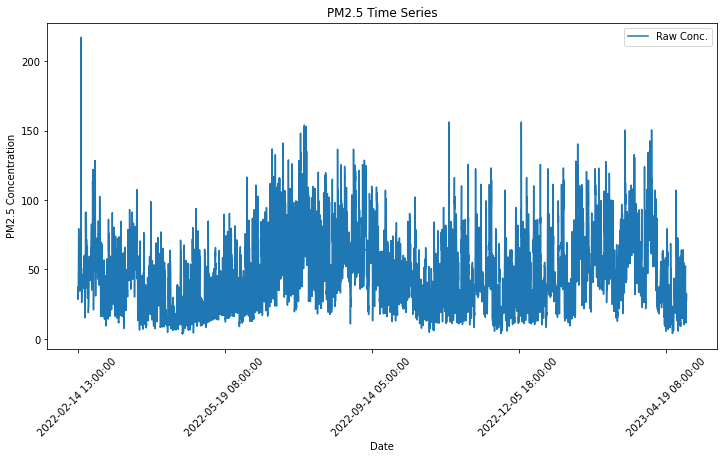

In [216]:
data1.plot(x='Date', y='Raw Conc.', figsize=(12, 6))
plt.title('PM2.5 Time Series')
plt.ylabel('PM2.5 Concentration')
plt.xticks(rotation=45)  # Rotate the date labels by 45 degrees
plt.show()

In [217]:
data=pd.read_csv('/home/consolee/Desktop/AIMS-Project/data.csv',index_col="Date")
data

,Raw Conc.
Date,
2022-02-14 13:00:00,28.9
2022-02-14 14:00:00,30.4
2022-02-14 15:00:00,28.7
2022-02-14 16:00:00,31.4
2022-02-14 17:00:00,33.2
...,...
2023-04-30 20:00:00,19.1
2023-04-30 21:00:00,26.6
2023-04-30 22:00:00,30.0


In [218]:
data.shape

(8281, 1)

In [278]:
prop_train = 0.8
n_train = round(prop_train * len(data))
n_test = len(data) - n_train

train_set = data.iloc[:n_train, :]
test_set = data.iloc[n_train:n_train+n_test, :]

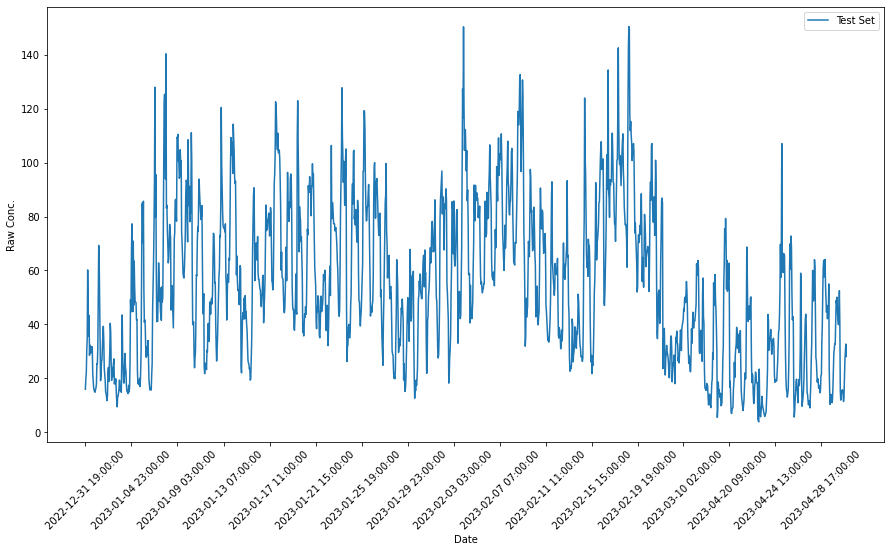

In [279]:
plt.figure(figsize=(15, 8))
plt.plot(data.index[n_train:], test_set, label='Test Set')
plt.xlabel('Date')
plt.ylabel('Raw Conc.')

# Specify the range of x-axis tick labels to display
x_tick_range = slice(0, len(test_set), 100)  # Adjust the step size as needed

# Set the x-axis tick locations and labels
plt.xticks(data.index[n_train:][x_tick_range], data.index[n_train:][x_tick_range], rotation=45)
plt.legend()
plt.show()

In [280]:
train_data = train_set.values
test_data = test_set.values

#####################
# Selecting the timesteps
timesteps=5
# Converting data to 2D tensor

train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
print(train_data_timesteps.shape)

# Converting test data to 2D tensor

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
print(test_data_timesteps.shape)

(6621, 5)
(1652, 5)


In [281]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(6621, 4) (6621, 1)
(1652, 4) (1652, 1)


# Combination of kernels

In [282]:
######model development####
kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(10)  + WhiteKernel(5)
model = GaussianProcessRegressor(kernel=kernel)
model.fit(x_train, y_train[:,0])
y_pred, std = model.predict(x_test, return_std=True)

In [283]:
y_pred = model.predict(x_test).reshape(-1,1)

In [284]:
y_pred

array([[38.10436556],
       [40.61828229],
       [67.10623122],
       ...,
       [34.12203039],
       [36.71540437],
       [37.86381993]])

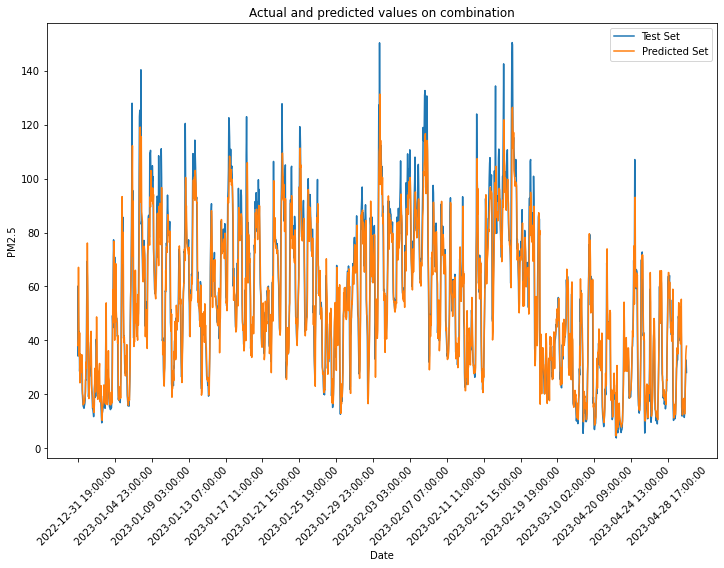

In [285]:
fig=plt.figure(figsize=(12, 8))
plt.plot(data.index[n_train:n_train+len(y_test)], y_test, label='Test Set')
plt.plot(data.index[n_train:n_train+len(y_pred)], y_pred, label='Predicted Set')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.xticks(data.index[n_train:n_train+len(y_test)][::100], rotation=45)
plt.title('Actual and predicted values on combination')
fig.savefig('Actual and predicted values on combination.png')
plt.legend()
plt.show()

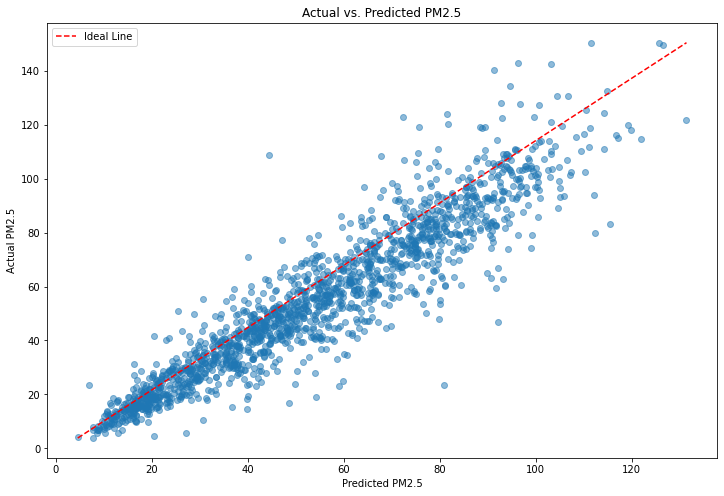

In [227]:
fig=plt.figure(figsize=(12, 8))
plt.scatter(y_pred, y_test, alpha=0.5)
plt.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line')
plt.xlabel('Predicted PM2.5')
plt.ylabel('Actual PM2.5')
plt.title('Actual vs. Predicted PM2.5')
fig.savefig('Actual vs. Predicted PM2.5 on comb.png')
plt.legend()
plt.show()

In [228]:
# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print("R-squared:", r2)
print("RMSE:", rmse)
print("MAE:", mae)

R-squared: 0.8704232049118453
RMSE: 10.345943902497616
MAE: 7.217155935939088


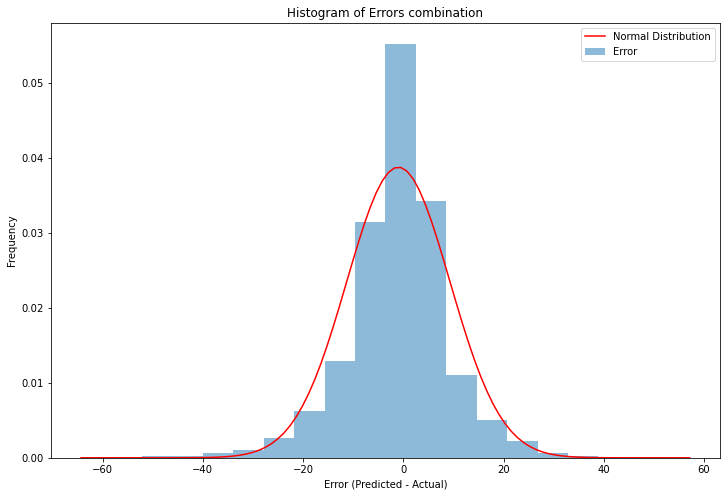

In [234]:
# Calculate the residuals
residuals = y_pred - y_test

# Plot the histogram of residuals
fig=plt.figure(figsize=(12, 8))
plt.hist(residuals, bins=20, density=True, alpha=0.5, label='Error')

# Generate points along the x-axis for the normal distribution curve
x = np.linspace(min(residuals), max(residuals), 100)
# Calculate the mean and standard deviation of the residuals
mean = np.mean(residuals)
std = np.std(residuals)
# Calculate the corresponding y-values of the normal distribution PDF
y = stats.norm.pdf(x, mean, std)
# Plot the normal distribution curve
plt.plot(x, y, color='red', label='Normal Distribution')

plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Histogram of Errors combination')
fig.savefig('Histogram of Errors combination.png')
plt.legend()
plt.show()

# RBF kernel

In [287]:
k0 = RBF(1.0)  # RBF kernel with a length scale of 10
model = GaussianProcessRegressor(kernel=k0)
model.fit(x_train, y_train[:, 0])
y_pred, std = model.predict(x_test, return_std=True)

In [288]:
y_pred = model.predict(x_test).reshape(-1,1)

In [289]:
y_pred

array([[34.3],
       [60.2],
       [12.9],
       ...,
       [30. ],
       [32.7],
       [28.1]])

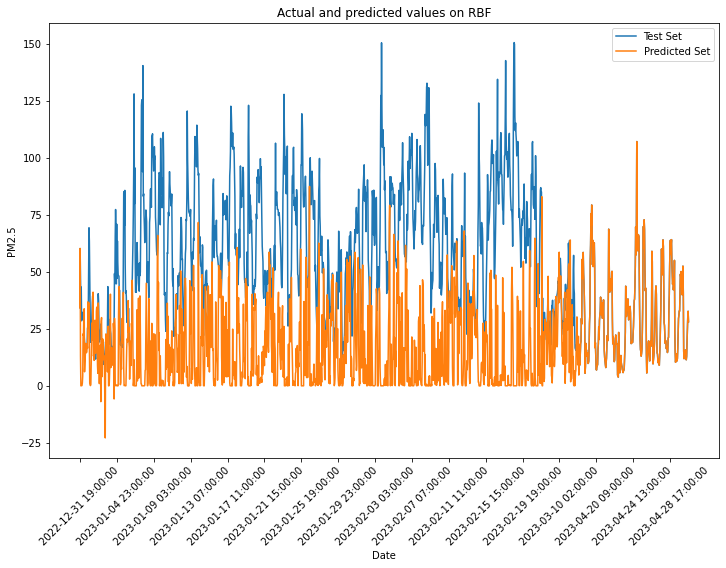

In [290]:
fig=plt.figure(figsize=(12, 8))
plt.plot(data.index[n_train:n_train+len(y_test)], y_test, label='Test Set')
plt.plot(data.index[n_train:n_train+len(y_pred)], y_pred, label='Predicted Set')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.xticks(data.index[n_train:n_train+len(y_test)][::100], rotation=45)
plt.title('Actual and predicted values on RBF')
fig.savefig('Actual and predicted values on RBF.png')
plt.legend()
plt.show()

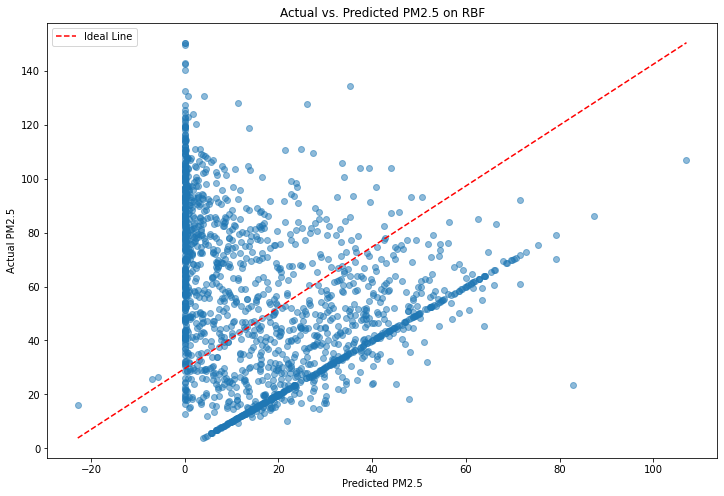

In [239]:
fig=plt.figure(figsize=(12, 8))
plt.scatter(y_pred, y_test, alpha=0.5)
plt.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line')
plt.xlabel('Predicted PM2.5')
plt.ylabel('Actual PM2.5')
plt.title('Actual vs. Predicted PM2.5 on RBF')
fig.savefig('Actual vs. Predicted PM2.5 on RBF.png')
plt.legend()
plt.show()

In [240]:
# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print("R-squared:", r2)
print("RMSE:", rmse)
print("MAE:", mae)

R-squared: -2.2676243634831854
RMSE: 51.954427669823986
MAE: 37.88556740014973


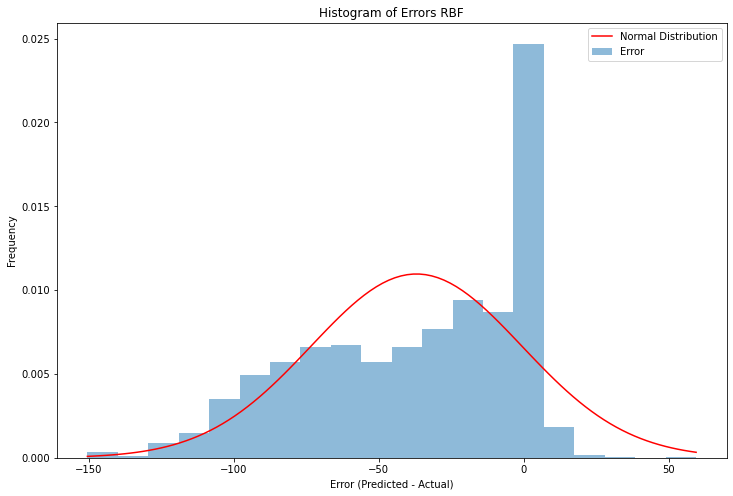

In [241]:
# Calculate the residuals
residuals = y_pred - y_test

# Plot the histogram of residuals
fig=plt.figure(figsize=(12, 8))
plt.hist(residuals, bins=20, density=True, alpha=0.5, label='Error')

# Generate points along the x-axis for the normal distribution curve
x = np.linspace(min(residuals), max(residuals), 100)
# Calculate the mean and standard deviation of the residuals
mean = np.mean(residuals)
std = np.std(residuals)
# Calculate the corresponding y-values of the normal distribution PDF
y = stats.norm.pdf(x, mean, std)
# Plot the normal distribution curve
plt.plot(x, y, color='red', label='Normal Distribution')

plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Histogram of Errors RBF')
fig.savefig('Histogram of Errors RBF.png')
plt.legend()
plt.show()

# Constant kernel

In [242]:
k1 = ConstantKernel(1.0)
model = GaussianProcessRegressor(kernel=k1)
model.fit(x_train, y_train[:, 0])
y_pred, std = model.predict(x_test, return_std=True)

In [243]:
y_pred = model.predict(x_test).reshape(-1,1)

In [244]:
y_pred

array([[46.20220947],
       [46.20220947],
       [46.20220947],
       ...,
       [46.22833252],
       [46.22833252],
       [46.21685791]])

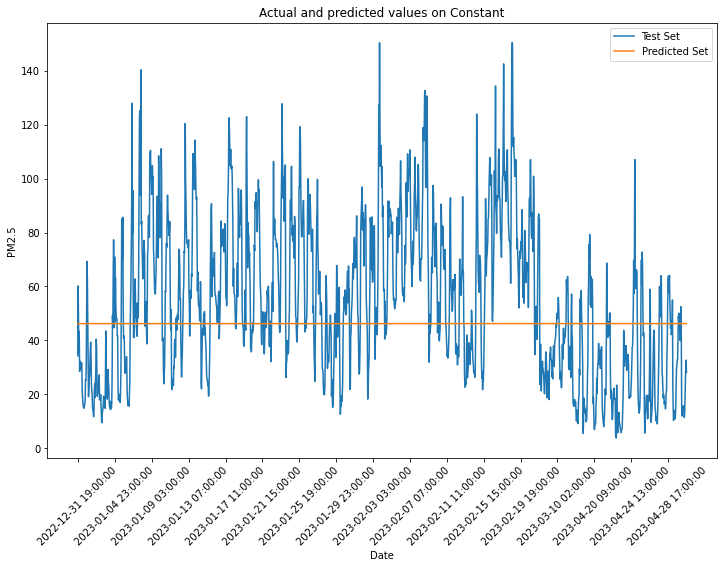

In [245]:
fig=plt.figure(figsize=(12, 8))
plt.plot(data.index[n_train:n_train+len(y_test)], y_test, label='Test Set')
plt.plot(data.index[n_train:n_train+len(y_pred)], y_pred, label='Predicted Set')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.xticks(data.index[n_train:n_train+len(y_test)][::100], rotation=45)
plt.title('Actual and predicted values on Constant')
fig.savefig('Actual vs predicted values on Constant.png')
plt.legend()
plt.show()

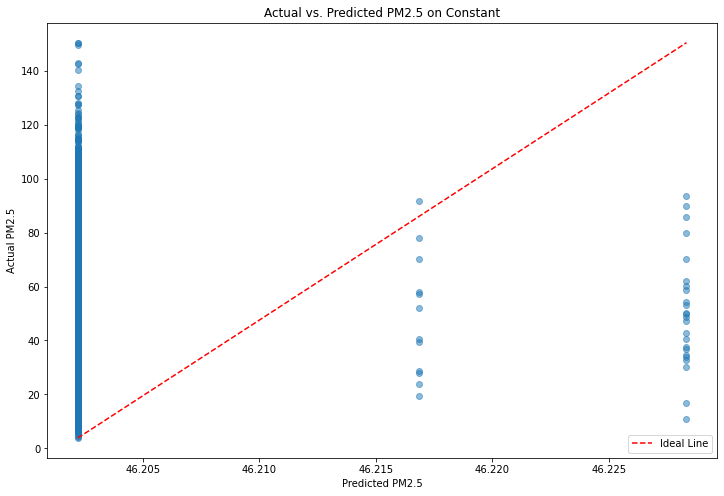

In [246]:
fig=plt.figure(figsize=(12, 8))
plt.scatter(y_pred, y_test, alpha=0.5)
plt.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line')
plt.xlabel('Predicted PM2.5')
plt.ylabel('Actual PM2.5')
plt.title('Actual vs. Predicted PM2.5 on Constant')
fig.savefig('Actual vs. Predicted PM2.5 on Constant.png')
plt.legend()
plt.show()

In [247]:
# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print("R-squared:", r2)
print("RMSE:", rmse)
print("MAE:", mae)

R-squared: -0.09510975675184885
RMSE: 30.077056135426794
MAE: 24.252513303595073


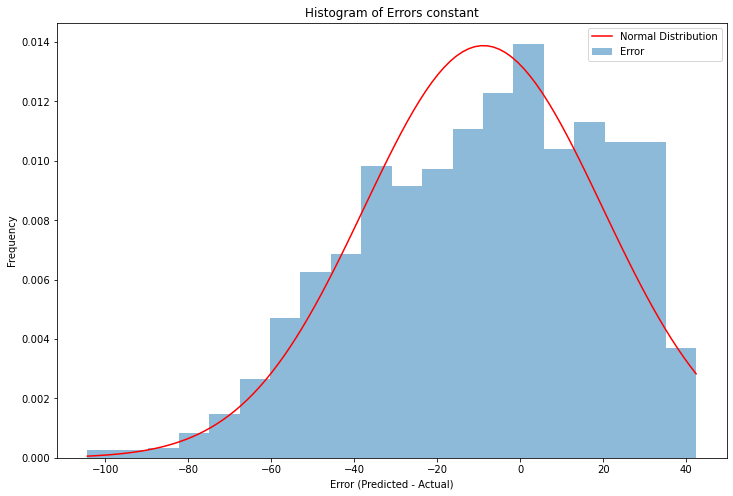

In [248]:
# Calculate the residuals
residuals = y_pred - y_test

# Plot the histogram of residuals
fig=plt.figure(figsize=(12, 8))
plt.hist(residuals, bins=20, density=True, alpha=0.5, label='Error')

# Generate points along the x-axis for the normal distribution curve
x = np.linspace(min(residuals), max(residuals), 100)
# Calculate the mean and standard deviation of the residuals
mean = np.mean(residuals)
std = np.std(residuals)
# Calculate the corresponding y-values of the normal distribution PDF
y = stats.norm.pdf(x, mean, std)
# Plot the normal distribution curve
plt.plot(x, y, color='red', label='Normal Distribution')

plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Histogram of Errors constant')
fig.savefig('Histogram of Errors constant.png')
plt.legend()
plt.show()

# ConstantKernel (0.009)

In [249]:
k2 = ConstantKernel(0.009)
model = GaussianProcessRegressor(kernel=k2)
model.fit(x_train, y_train[:, 0])
y_pred, std = model.predict(x_test, return_std=True)

In [250]:
y_pred = model.predict(x_test).reshape(-1,1)

In [251]:
y_pred

array([[46.2651701 ],
       [46.2651701 ],
       [46.2651701 ],
       ...,
       [46.26947308],
       [46.26947308],
       [46.26515865]])

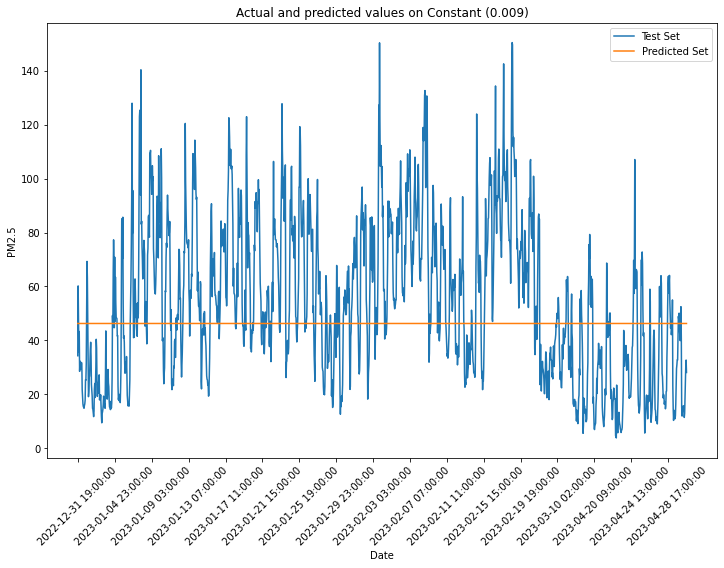

In [252]:
fig=plt.figure(figsize=(12, 8))
plt.plot(data.index[n_train:n_train+len(y_test)], y_test, label='Test Set')
plt.plot(data.index[n_train:n_train+len(y_pred)], y_pred, label='Predicted Set')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.xticks(data.index[n_train:n_train+len(y_test)][::100], rotation=45)
plt.title('Actual and predicted values on Constant (0.009)')
fig.savefig('Actual vs predicted values on Constant (0.009.png')
plt.legend()
plt.show()

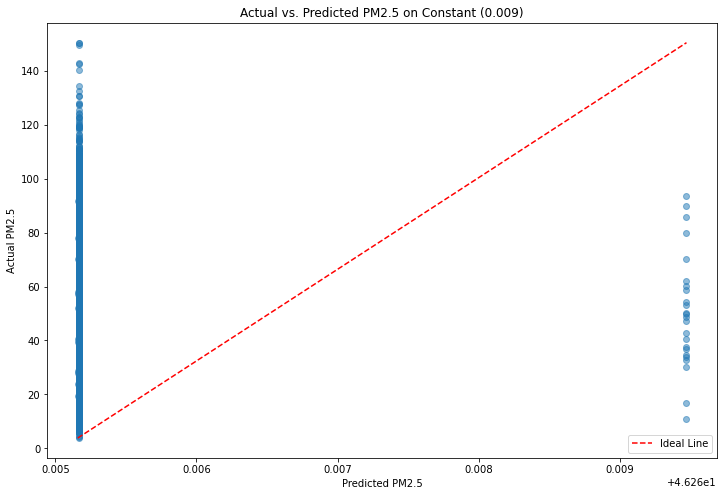

In [253]:
fig=plt.figure(figsize=(12, 8))
plt.scatter(y_pred, y_test, alpha=0.5)
plt.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line')
plt.xlabel('Predicted PM2.5')
plt.ylabel('Actual PM2.5')
plt.title('Actual vs. Predicted PM2.5 on Constant (0.009)')
fig.savefig('Actual vs. Predicted PM2.5 on Constant (0.009.png')
plt.legend()
plt.show()

In [254]:
# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print("R-squared:", r2)
print("RMSE:", rmse)
print("MAE:", mae)

R-squared: -0.0937676466133095
RMSE: 30.05862003933853
MAE: 24.243190644151074


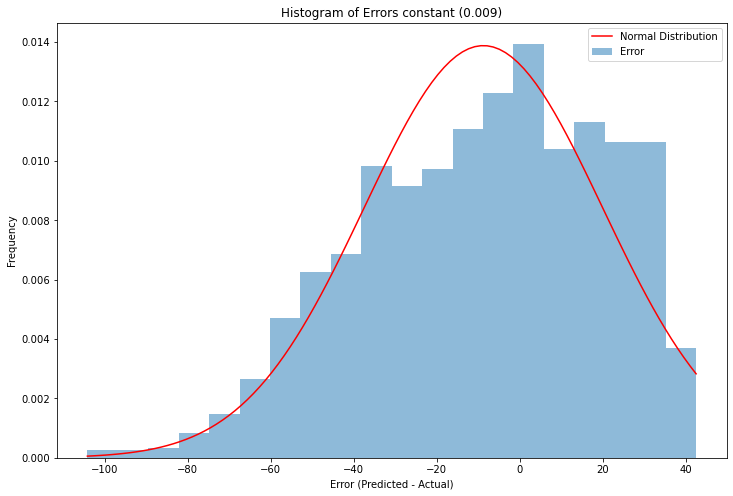

In [255]:
# Calculate the residuals
residuals = y_pred - y_test

# Plot the histogram of residuals
fig=plt.figure(figsize=(12, 8))
plt.hist(residuals, bins=20, density=True, alpha=0.5, label='Error')

# Generate points along the x-axis for the normal distribution curve
x = np.linspace(min(residuals), max(residuals), 100)
# Calculate the mean and standard deviation of the residuals
mean = np.mean(residuals)
std = np.std(residuals)
# Calculate the corresponding y-values of the normal distribution PDF
y = stats.norm.pdf(x, mean, std)
# Plot the normal distribution curve
plt.plot(x, y, color='red', label='Normal Distribution')

plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Histogram of Errors constant (0.009)')
fig.savefig('Histogram of Errors constant (0.009).png')
plt.legend()
plt.show()

# Daily Average

In [298]:
data1['Date'] = pd.to_datetime(data1['Date'])
data1.set_index('Date', inplace=True)  # Set 'Date' column as the index
data_daily = data1['Raw Conc.'].groupby(pd.Grouper(freq='D')).mean()
data_daily = data_daily.interpolate()
data_daily = pd.DataFrame(data_daily, columns=['Raw Conc.'])
data_daily

,Raw Conc.
Date,
2022-02-14,36.927273
2022-02-15,55.412500
2022-02-16,53.700000
2022-02-17,41.312500
2022-02-18,47.145833
...,...
2023-04-27,23.391667
2023-04-28,34.387500
2023-04-29,33.554167


<AxesSubplot:xlabel='Date'>

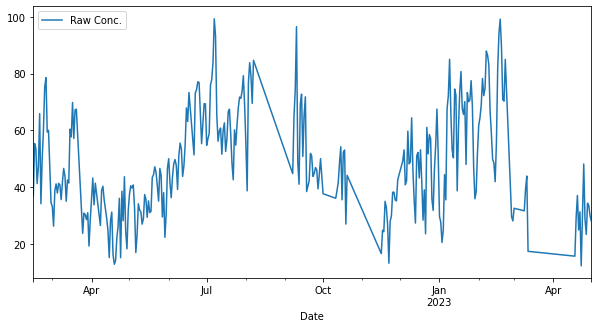

In [299]:
data_daily.plot(figsize=(10,5))

In [300]:
data_daily.shape

(442, 1)

In [301]:
prop_train = 0.8
n_train = round(prop_train * len(data_daily))
n_test = len(data_daily) - n_train

train_set = data_daily.iloc[:n_train, :]
test_set = data_daily.iloc[n_train:n_train+n_test, :]

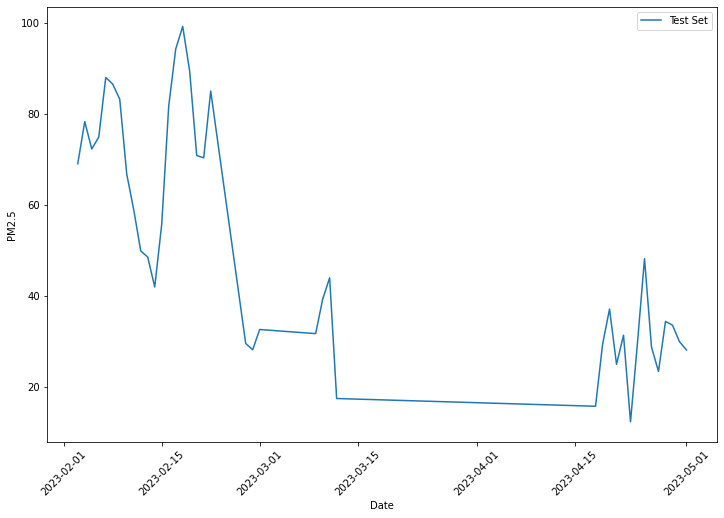

In [302]:
plt.figure(figsize=(12, 8))
plt.plot(data_daily.index[n_train:], test_set, label='Test Set')
plt.xlabel('Date')
plt.ylabel('PM2.5')

# Set the x-axis tick locations and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [303]:
train_data = train_set.values
test_data = test_set.values

#####################
# Selecting the timesteps
timesteps=5
# Converting data to 2D tensor

train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
print(train_data_timesteps.shape)

# Converting test data to 2D tensor

test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
print(test_data_timesteps.shape)

(350, 5)
(84, 5)


In [304]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(350, 4) (350, 1)
(84, 4) (84, 1)


In [305]:
######model development####
kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(10)  + WhiteKernel(5)
model = GaussianProcessRegressor(kernel=kernel)
model.fit(x_train, y_train[:,0])
y_pred, std = model.predict(x_test, return_std=True)

In [306]:
# Making predictions
y_pred = model.predict(x_test).reshape(-1,1)

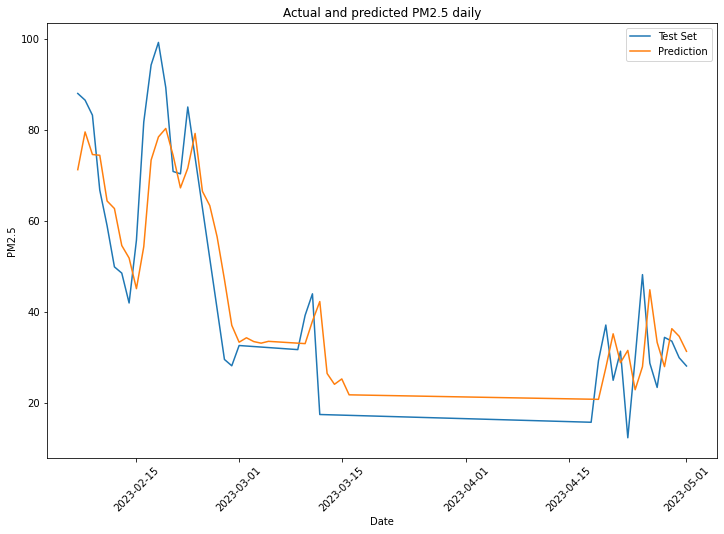

In [307]:
fig=plt.figure(figsize=(12, 8))
plt.plot(data_daily.index[n_train+timesteps-1:n_train+timesteps-1+len(test_set)], test_set.values[timesteps-1:].ravel(), label='Test Set')
plt.plot(data_daily.index[n_train+timesteps-1:], y_pred, label='Prediction')
plt.xlabel('Date')
plt.ylabel('PM2.5')

# Set the x-axis tick locations and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title('Actual and predicted PM2.5 daily')
fig.savefig('Actual and predicted PM2.5 daily.png')
plt.xticks(rotation=45)
plt.legend()
plt.show()

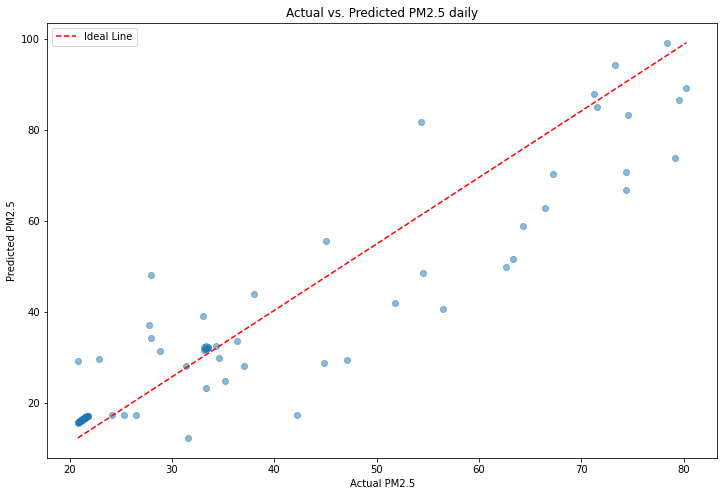

In [309]:
fig=plt.figure(figsize=(12, 8))
plt.scatter(y_pred, y_test, alpha=0.5)
plt.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs. Predicted PM2.5 daily')
fig.savefig('Actual vs. Predicted PM2.5 daily.png')
plt.legend()
plt.show()

In [267]:
# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

# Print the evaluation metrics
print("R-squared:", r2)
print("RMSE:", rmse)
print("MAE:", mae)

R-squared: 0.8475206189367768
RMSE: 9.015878599758754
MAE: 7.149664434914636


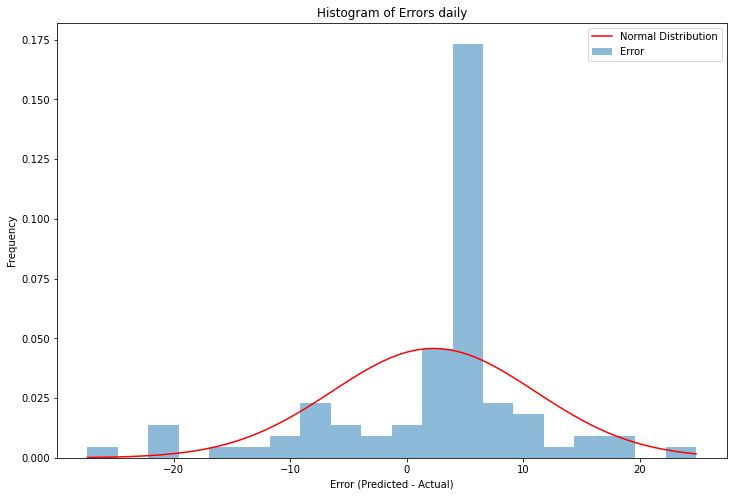

In [268]:
# Calculate the residuals
residuals = y_pred - y_test

# Plot the histogram of residuals
fig=plt.figure(figsize=(12, 8))
plt.hist(residuals, bins=20, density=True, alpha=0.5, label='Error')

# Generate points along the x-axis for the normal distribution curve
x = np.linspace(min(residuals), max(residuals), 100)
# Calculate the mean and standard deviation of the residuals
mean = np.mean(residuals)
std = np.std(residuals)
# Calculate the corresponding y-values of the normal distribution PDF
y = stats.norm.pdf(x, mean, std)
# Plot the normal distribution curve
plt.plot(x, y, color='red', label='Normal Distribution')

plt.xlabel('Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Histogram of Errors daily')
fig.savefig('Histogram of Errors daily.png')
plt.legend()
plt.show()